# Etapa 1

## 1.1 Entendimiento del negocio y enfoque analítico

### 1.1.1 Oportunidad/Problema negocio

Categorizar los comentarios de las peliculas en positivos o negativos


### 1.1.2 Enfoque analítico

(Descripción del
requerimiento desde el
punto de vista de
aprendizaje automático)

Uso de tecnicas de aprendizaje automatico(machine learning) y procesamiento de lenguaje natural que tienen como objetivo principal procesar de manera automatica grandes cantidades de texto de los comentarios de las peliculas para poder clasificarlos en positivos o negativos


### 1.1.3 Organización y rol dentro de ella que se beneficia con la oportunidad definida

### 1.1.4 Técnicas y algoritmos a utilizar

a.) Tipo de aprendizaje : supervisado

b.) Tarea de aprendizaje : Clasificación 

c.) Tecnicas de aprendizaje : 

        1. SVM(Máquinas de vectores de soporte)
        2. Regresión logística
        3. Arboles de decisión


## 1.2 Entendimiento y preparación de los datos

### 1.2.1 Carga de los datos

In [1]:
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import contractions
import inflect
import pandas_profiling
import re
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib as mplt
import matplotlib.pyplot as plt
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')




nltk.data.path.append(os.path.abspath('./nltk_data'))
nltk.download('punkt', quiet=True, raise_on_error=True, download_dir='./nltk_data')
nltk.download('stopwords', quiet=True, raise_on_error=True, download_dir='./nltk_data')
nltk.download('wordnet', quiet=True, raise_on_error=True, download_dir='./nltk_data')
ROOT_DIR = os.path.abspath(os.curdir)
NLTK_DATA_DIR = os.path.join(ROOT_DIR, 'nltk_data')
nltk.data.path.append(NLTK_DATA_DIR)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stopwords_spanish = stopwords.words('spanish')
lemmatizer = WordNetLemmatizer()

df_movies = pd.read_csv('./data/MovieReviews.csv',
                        sep=',',
                        encoding='utf-8',
                        index_col=0)

# random_df = df_movies.sample(n=len(df_movies), replace=True)
# random_df.to_csv("./data/randomMovieReviews.csv", index=False)

# df_movies = pd.read_csv('./data/randomMovieReviews.csv',
#                         sep=',',
#                         encoding='utf-8',
#                         index_col=None)º

### 1.2.2 Entendimiento de los datos

In [2]:
df_movies.shape

(5000, 2)

In [3]:
df_movies.head()

,review_es,sentimiento
0,Si está buscando una película de guerra típica...,positivo
1,Supongo que algunos directores de películas de...,positivo
2,Es difícil contarle más sobre esta película si...,positivo
3,"La película comienza muy lentamente, con el es...",positivo
4,Esta película es verdadera acción en su máxima...,positivo


In [4]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_es    5000 non-null   object
 1   sentimiento  5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [5]:
# Se calcula el porcentaje de los valores nulos por columna
print((df_movies.isnull().sum()*100 / df_movies.shape[0]).sort_values(ascending=False))

review_es      0.0
sentimiento    0.0
dtype: float64


In [6]:
# Analizar la duplicidad de los datos
df_movies.duplicated().sum()

2

<AxesSubplot:>

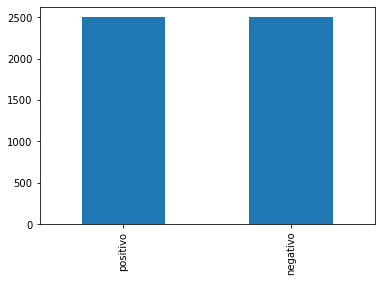

In [7]:
# Analizar distribución de la variable categórica
df_movies['sentimiento'].value_counts().plot(kind='bar')

In [8]:
# Para analizar la columna de review_es vamos a ver los reviews con menos de 30 caracteres
short_reviews = df_movies[df_movies['review_es'].str.len() < 50]
print(short_reviews)

Empty DataFrame
Columns: [review_es, sentimiento]
Index: []


Como puede evidenciarse, no hay filas con reviews cortos o vacíos que se podrían considerar como atípicos.

In [9]:
short_reviews = df_movies[df_movies['review_es'].str.len() < 61]
print(short_reviews)

# El review más corto tiene 61 caracteres, lo cual es un número apropiado.
print(short_reviews['review_es'])

                                              review_es sentimiento
4421  Esta película es terrible pero tiene algunos b...    negativo
4421    Esta película es terrible pero tiene algunos b...
Name: review_es, dtype: object


### 1.2.3 Preparación de los datos

In [10]:
# Se cambian los valores a numéricos
df_movies['sentimiento'] = df_movies['sentimiento'].replace({'positivo': 1, 'negativo': 0})

In [11]:
df_movies.head()

,review_es,sentimiento
0,Si está buscando una película de guerra típica...,1
1,Supongo que algunos directores de películas de...,1
2,Es difícil contarle más sobre esta película si...,1
3,"La película comienza muy lentamente, con el es...",1
4,Esta película es verdadera acción en su máxima...,1


In [12]:
df_movies.dtypes

review_es      object
sentimiento     int64
dtype: object

1    2500
0    2500
Name: sentimiento, dtype: int64


<AxesSubplot:>

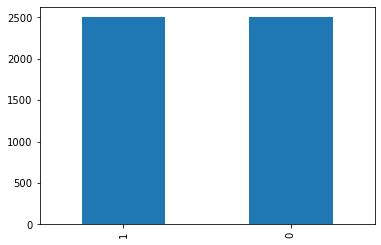

In [13]:
# Analizar distribución de la variable categórica
print(df_movies['sentimiento'].value_counts())
df_movies['sentimiento'].value_counts().plot(kind='bar',)

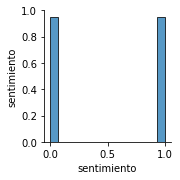

In [14]:
sns.pairplot(df_movies)

Finalmente, se eliminan los valores duplicados, los cuales solo eran 2.

In [15]:
print("Cantidad de datos duplicados: ",df_movies.duplicated().sum())
df_movies.drop_duplicates(inplace=True)
print("Cantidad de datos duplicados después: ",df_movies.duplicated().sum())

df_movies.shape

Cantidad de datos duplicados:  2
Cantidad de datos duplicados después:  0


(4998, 2)

En conclusión, se tienen 4998 filas para crear el modelo.

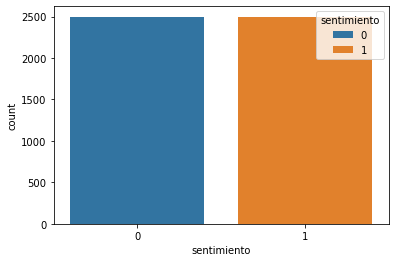

In [16]:
ax = sns.countplot(x="sentimiento", hue="sentimiento", data=df_movies, dodge=False)

In [17]:
df_movies.head(20)

,review_es,sentimiento
0,Si está buscando una película de guerra típica...,1
1,Supongo que algunos directores de películas de...,1
2,Es difícil contarle más sobre esta película si...,1
3,"La película comienza muy lentamente, con el es...",1
4,Esta película es verdadera acción en su máxima...,1
5,Así como un fanático de la vida de las películ...,1
6,"El polvo rojo está bien actuado y bien hecho, ...",1
7,Los talentos de Abbott y Costello brillan en l...,1
8,Asesina sexy Tiffany (Jennifer Tilly) todavía ...,1
9,"Si mis expectativas no se superaron, ciertamen...",1


### 1.2.4 Procesamiento de lenguaje natural

In [18]:

def preprocessor(text):
     text = re.sub('<[^>]*>', '', text)
     emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                            text)
     text = (re.sub('[\W]+', ' ', text.lower()) +
             ' '.join(emoticons).replace('-', ''))
     return text

In [19]:
df_movies['review_es'] = df_movies['review_es'].apply(preprocessor)

In [20]:
df_movies.head(20)

,review_es,sentimiento
0,si está buscando una película de guerra típica...,1
1,supongo que algunos directores de películas de...,1
2,es difícil contarle más sobre esta película si...,1
3,la película comienza muy lentamente con el est...,1
4,esta película es verdadera acción en su máxima...,1
5,así como un fanático de la vida de las películ...,1
6,el polvo rojo está bien actuado y bien hecho p...,1
7,los talentos de abbott y costello brillan en l...,1
8,asesina sexy tiffany jennifer tilly todavía an...,1
9,si mis expectativas no se superaron ciertament...,1


In [21]:

# nltk.download('stopwords')
# stop_words= set(stopwords.words('spanish'))

In [22]:
# Función para tokenizar los tweets
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

In [23]:
# El parámetro 'stratify' es útil para asegurar que ambos conjuntos de datos queden aproximadamente balanceados
# Cuando se cuenta con muy pocos datos etiquetados, por lo general se debe disponer de una menor cantidad de datos para evaluación
X_train, X_test, Y_train, Y_test = train_test_split(df_movies['review_es'], df_movies['sentimiento'], test_size = 0.3, stratify = df_movies['sentimiento'], random_state = 1)

In [24]:
X_train.shape

(3498,)

In [25]:
pd.Series(Y_train).value_counts(normalize = True)

1    0.5
0    0.5
Name: sentimiento, dtype: float64

In [26]:
X_test.shape

(1500,)

In [27]:
pd.Series(Y_test).value_counts(normalize = True)

1    0.5
0    0.5
Name: sentimiento, dtype: float64

## Vectorización

In [28]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stopwords_spanish, lowercase = True)


In [29]:
X_bow = bow.fit_transform(X_train)

In [30]:
len(bow.vocabulary_)

47097

In [31]:
tfidf=TfidfVectorizer(tokenizer=tokenizer, stop_words=stopwords_spanish, lowercase=True)

In [32]:
X_tfidf = tfidf.fit_transform(X_train)

In [33]:
len(tfidf.vocabulary_)

47097

## 1.3 Modelo y evaluación
Se requiere que llas variables de entrada estén separadas de la variable objetivo.

### 1.3.1 Modelo con Support Vector Machines (SVMs)

#### 1.3.1.1 Construcción del modelo BOW

In [171]:
# Create a svm Classifier
bow_clf = svm.SVC(kernel='linear') # Linear Kernel

# Entrenar el modelo utilizando X_box y Y_train
bow_clf.fit(X_bow, Y_train)

y_train_bow_predict = bow_clf.predict(X_bow)
y_test_bow_predict = bow_clf.predict(bow.transform(X_test))

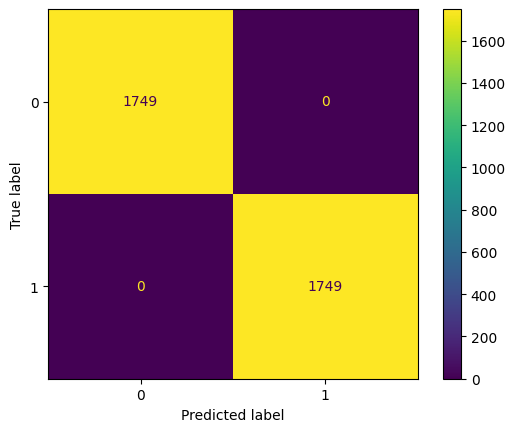

In [172]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_train, y_train_bow_predict)

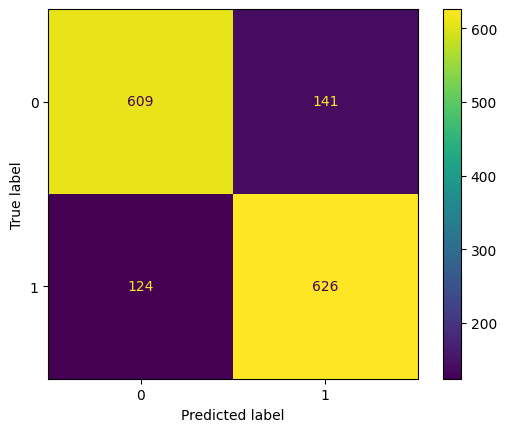

In [173]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_test_bow_predict)

In [174]:
if len(bow_clf.classes_) == 2:
    print('Precision:', metrics.precision_score(Y_train, y_train_bow_predict, pos_label = 1))
    print('Recall:', metrics.recall_score(Y_train, y_train_bow_predict, pos_label = 1))
    print('F1:', metrics.f1_score(Y_train, y_train_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', metrics.precision_score(Y_train, y_train_bow_predict, average = None))
    print('Recall:', metrics.recall_score(Y_train, y_train_bow_predict, average = None))
    print('F1:', metrics.f1_score(Y_train, y_train_bow_predict, average = None))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [175]:
if len(bow_clf.classes_) == 2:
    print('Precision:', metrics.precision_score(Y_test, y_test_bow_predict, pos_label = 1))
    print('Recall:', metrics.recall_score(Y_test, y_test_bow_predict, pos_label = 1))
    print('F1:', metrics.f1_score(Y_test, y_test_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', metrics.precision_score(Y_test, y_test_bow_predict, average = None))
    print('Recall:', metrics.recall_score(Y_test, y_test_bow_predict, average = None))
    print('F1:', metrics.f1_score(Y_test, y_test_bow_predict, average = None))

Precision: 0.8161668839634941
Recall: 0.8346666666666667
F1: 0.8253131179960449


#### 1.3.1.2 Construcción del modelo con TD-IDF

In [176]:
tfidf_clf = svm.SVC(kernel='linear') # Linear Kernel

tfidf_clf.fit(X_tfidf, Y_train)

SVC(kernel='linear')

In [177]:
y_train_tfidf_predict = tfidf_clf.predict(X_tfidf)
y_test_tfidf_predict = tfidf_clf.predict(tfidf.transform(X_test))

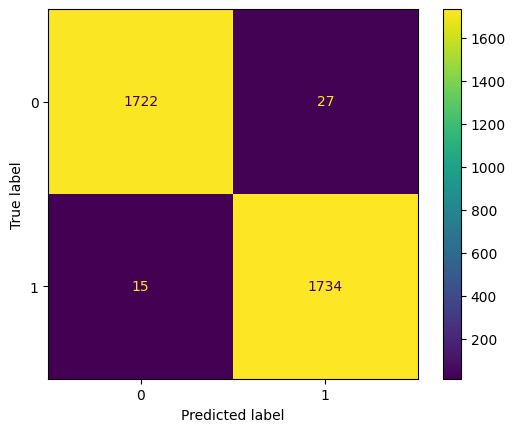

In [178]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_train, y_train_tfidf_predict)

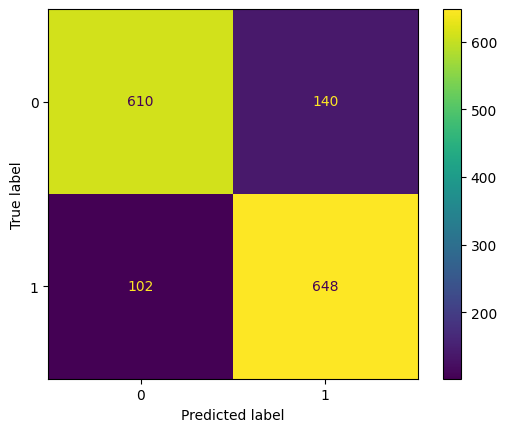

In [179]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_test_tfidf_predict)

In [180]:
if len(bow_clf.classes_) == 2:
    print('Precision:', metrics.precision_score(Y_train, y_train_tfidf_predict, pos_label = 1))
    print('Recall:', metrics.recall_score(Y_train, y_train_tfidf_predict, pos_label = 1))
    print('F1:', metrics.f1_score(Y_train, y_train_tfidf_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', metrics.precision_score(Y_train, y_train_tfidf_predict, average = None))
    print('Recall:', metrics.recall_score(Y_train, y_train_tfidf_predict, average = None))
    print('F1:', metrics.f1_score(Y_train, y_train_tfidf_predict, average = None))

Precision: 0.9846678023850085
Recall: 0.9914236706689536
F1: 0.9880341880341881


In [181]:
if len(tfidf_clf.classes_) == 2:
    print('Precision:', metrics.precision_score(Y_test, y_test_tfidf_predict, pos_label = 1))
    print('Recall:', metrics.recall_score(Y_test, y_test_tfidf_predict, pos_label = 1))
    print('F1:', metrics.f1_score(Y_test, y_test_tfidf_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', metrics.precision_score(Y_test, y_test_tfidf_predict, average = None))
    print('Recall:', metrics.recall_score(Y_test, y_test_tfidf_predict, average = None))
    print('F1:', metrics.f1_score(Y_test, y_test_tfidf_predict, average = None))

Precision: 0.8223350253807107
Recall: 0.864
F1: 0.8426527958387517


#### 1.3.1.3 Análisis del error

In [182]:
error_df = pd.concat([
    pd.concat([X_test, Y_test], axis = 1).reset_index(),
    pd.Series(y_test_tfidf_predict)
], axis = 1).rename(columns = { 'sentimiento': 'actual', 0: 'predicted' })

error_df.drop('index', inplace = True, axis = 1)

In [183]:
error_df.loc[error_df['actual'] != error_df['predicted']].shape

(242, 3)

In [184]:
error_df.loc[error_df['actual'] != error_df['predicted']].sample(10)

,review_es,actual,predicted
123,es bastante evidente que muchas de tus noches ...,1,0
760,this film is mildly entertaining if one neglec...,0,1
1459,visitor q is a failed attempt at black comedy...,0,1
31,advertencia de spoiler absolutamente sin luga...,0,1
851,esta película es verdadera acción en su máxima...,1,0
1365,shakespeare habría sido indignado los escritor...,0,1
169,no sé si recomendar esta película a los fanáti...,1,0
1402,y yo por un caso eso es algo bueno nunca he si...,1,0
839,déjame estar por adelantado me gusta la pulpa ...,1,0
1495,me gustaría ventilar mi disgusto en nbc cancel...,1,0


### 1.3.2 Modelo con Regresión logistica

In [34]:

bow_model=LogisticRegression(random_state=2)

In [35]:
bow_model.fit(X_bow, Y_train)

LogisticRegression(random_state=2)

In [36]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test))

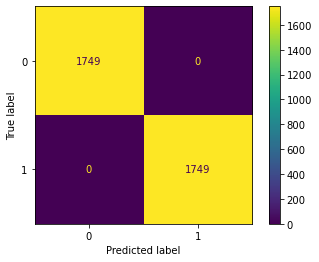

In [37]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_train, y_train_bow_predict)

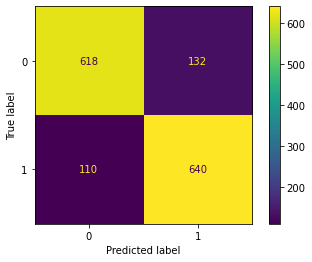

In [38]:
metrics.ConfusionMatrixDisplay.from_predictions( Y_test,y_test_bow_predict)

In [39]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(Y_train, y_train_bow_predict, pos_label = 1))
    print('Recall:', recall_score(Y_train, y_train_bow_predict, pos_label = 1))
    print('F1:', f1_score(Y_train, y_train_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(Y_train, y_train_bow_predict, average = None))
    print('Recall:', recall_score(Y_train, y_train_bow_predict, average = None))
    print('F1:', f1_score(Y_train, y_train_bow_predict, average = None))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [40]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(Y_test, y_test_bow_predict, pos_label = 1))
    print('Recall:', recall_score(Y_test, y_test_bow_predict, pos_label = 1))
    print('F1:', f1_score(Y_test, y_test_bow_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(Y_test, y_test_bow_predict, average = None))
    print('Recall:', recall_score(Y_test, y_test_bow_predict, average = None))
    print('F1:', f1_score(Y_test, y_test_bow_predict, average = None))

Precision: 0.8290155440414507
Recall: 0.8533333333333334
F1: 0.8409986859395532


#### 1.3.2.2 Modelo usando TF-IDF

In [41]:
tfidf_model = LogisticRegression(random_state = 3)

In [42]:
tfidf_model.fit(X_tfidf, Y_train)

LogisticRegression(random_state=3)

In [43]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test))

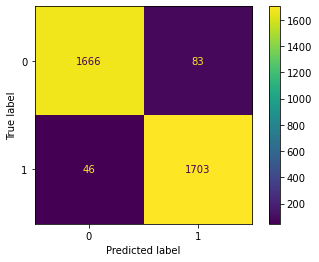

In [44]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_train, y_train_tfidf_predict)

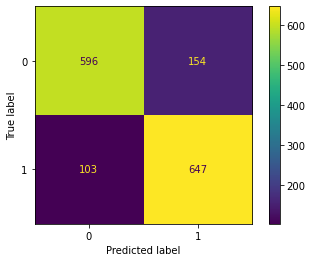

In [45]:
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_test_tfidf_predict)

In [46]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(Y_train, y_train_tfidf_predict, pos_label = 1))
    print('Recall:', recall_score(Y_train, y_train_tfidf_predict, pos_label = 1))
    print('F1:', f1_score(Y_train, y_train_tfidf_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(Y_train, y_train_tfidf_predict, average = None))
    print('Recall:', recall_score(Y_train, y_train_tfidf_predict, average = None))
    print('F1:', f1_score(Y_train, y_train_tfidf_predict, average = None))

Precision: 0.9535274356103024
Recall: 0.9736992567181246
F1: 0.9635077793493635


In [47]:
if len(tfidf_model.classes_) == 2:
    print('Precision:', precision_score(Y_test, y_test_tfidf_predict, pos_label = 1))
    print('Recall:', recall_score(Y_test, y_test_tfidf_predict, pos_label = 1))
    print('F1:', f1_score(Y_test, y_test_tfidf_predict, pos_label = 1))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(Y_test, y_test_tfidf_predict, average = None))
    print('Recall:', recall_score(Y_test, y_test_tfidf_predict, average = None))
    print('F1:', f1_score(Y_test, y_test_tfidf_predict, average = None))

Precision: 0.8077403245942572
Recall: 0.8626666666666667
F1: 0.8343004513217279


#### 1.3.2.3 Análisis del error

In [48]:
error_df = pd.concat([
    pd.concat([X_test, Y_test], axis = 1).reset_index(),
    pd.Series(y_test_tfidf_predict)
], axis = 1).rename(columns = { 'sentimiento': 'actual', 0: 'predicted' })

error_df.drop('index', inplace = True, axis = 1)

In [49]:
error_df.loc[error_df['actual'] != error_df['predicted']].shape

(257, 3)

In [50]:
error_df.loc[error_df['actual'] != error_df['predicted']].sample(10)

,review_es,actual,predicted
1234,i honestly don t know where to begin when revi...,0,1
437,puedo encontrar muy poco eso es bueno decir so...,0,1
175,durante mucho tiempo no he visto una caracterí...,1,0
641,ok así que siempre hay gente que parece que lo...,1,0
746,y así nació la mofeta más amorosa para adornar...,1,0
285,en primer lugar tengo que comenzar este coment...,1,0
685,grudeyman2 comentario a continuación usted es ...,1,0
44,martha pimpton ha hecho algunas películas pres...,0,1
725,los ochenta produjeron una gran cantidad de pe...,1,0
719,esta película es hilarante diría mucho más dol...,1,0


In [74]:

pipeline = Pipeline([
    ('vectorizer', None),
    ('classifier', LogisticRegression(random_state = 2))
])

In [75]:
param_grid = {
    'vectorizer': [CountVectorizer(tokenizer = tokenizer, stop_words = stopwords_spanish), TfidfVectorizer(tokenizer = tokenizer, stop_words = stopwords_spanish)],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.1,1,10],
}

In [76]:
search = GridSearchCV(pipeline, param_grid, scoring = ['precision', 'recall', 'f1'], refit = 'f1', cv = 10, return_train_score = True, verbose = 1)

In [77]:
search.fit(X_train, Y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vectorizer', None),
                                       ('classifier',
                                        LogisticRegression(random_state=2))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2'],
                         'vectorizer': [CountVectorizer(stop_words=['de', 'la',
                                                                    'que', 'el',
                                                                    'en', 'y',
                                                                    'a', 'los',
                                                                    'del', 'se',
                                                                    'las',
                                                                    'por', 'un',
                                                                    'para',
                                   

In [78]:
search.best_params_

{'classifier__C': 10,
 'classifier__penalty': 'l2',
 'vectorizer': TfidfVectorizer(stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                             'del', 'se', 'las', 'por', 'un', 'para', 'con',
                             'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                             'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                             'porque', ...],
                 tokenizer=<function tokenizer at 0x00000212B03F5C10>)}

In [79]:
search.best_score_

0.8502011497041512

In [80]:
y_test_search_predict = search.best_estimator_.predict(X_test)

In [81]:
print('Precision:', precision_score(Y_test, y_test_search_predict))
print('Recall:', recall_score(Y_test, y_test_search_predict))
print('F1:', f1_score(Y_test, y_test_search_predict))

Precision: 0.8301647655259823
Recall: 0.8733333333333333
F1: 0.8512020792722548


### 1.3.3 Arboles de decisión

In [202]:
# Crear la matriz de características TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df_movies['review_es'])

#Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df_movies['sentimiento'], test_size=0.3, random_state=42)

# Entrenar un árbol de decisión
arbol = DecisionTreeClassifier(criterion='entropy', random_state=0)
arbol.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred = arbol.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')
print("Recall: {}".format(recall_score(y_test,y_pred)))
print("Precisión: {}".format(precision_score(y_test,y_pred)))
print("Puntuación F1: {}".format(f1_score(y_test,y_pred)))



Precisión del modelo: 0.6626666666666666
Recall: 0.6566186107470511
Precisión: 0.6724832214765101
Puntuación F1: 0.6644562334217506


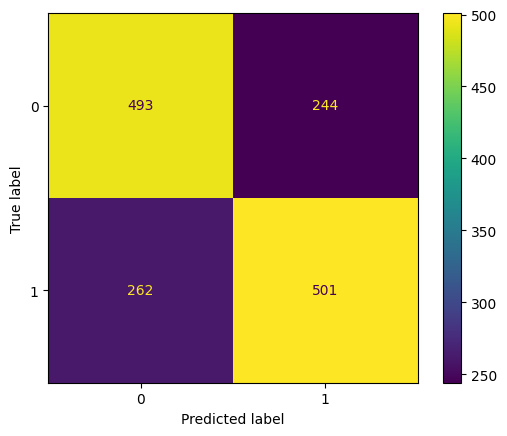

In [203]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### 1.3.2.4 Selección del modelo


## 1.4 Resultados


## 1.5 Trabajo en equipo